# Data Cleaning

In this file, we are going to clean our data and save the created dataframes for future analysis.

While we attempted to reduce the amount of cleaning required, via good survey design, there are still some cases that would require cleaning. 

## Import packages

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import utils
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from fuzzywuzzy import fuzz
import lightgbm as lgb
from category_encoders import BinaryEncoder

## Set Style Guide

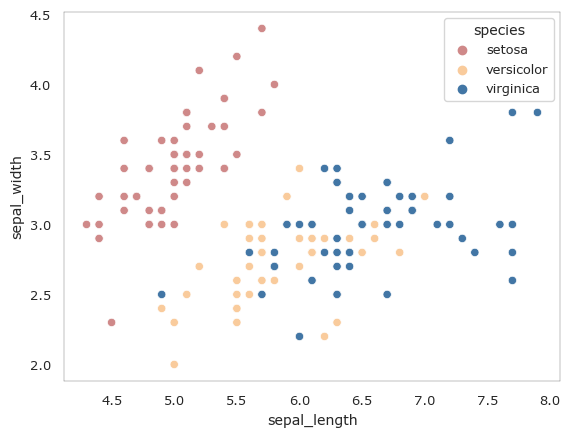

In [234]:
grey = "#eeeeee"
blue = "#4276A5"
red = "#cf8989"
cream = "#f9cb9c"
green = "#45818e"
pink = "#FF8FC3"

PALETTE = [red, cream, blue, green, pink, grey]
FONT = "Verdana"

# Set Seaborn style and color palette
sns.set(
    style="white", 
    palette=PALETTE, 
    context='notebook', 
    font=FONT, 
    font_scale=0.85, 
    color_codes=True
    )

# Set Matplotlib font
mpl.rcParams['font.family'] = FONT

# Set the desired axes border linewidth
mpl.rcParams['axes.linewidth'] = 0.2

# Example Seaborn plot
iris_data = sns.load_dataset("iris")
sns.scatterplot(data=iris_data, x="sepal_length", y="sepal_width", hue="species");

## Inspect data

Load data

In [235]:
data_filepath = "../data/strike_and_academic_performance.csv"

data = pd.read_csv(data_filepath)

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 21 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Are you a student of the University of Lagos?                                       431 non-null    object 
 1   If not, what is your university/institution?                                        22 non-null     object 
 2   What is your current academic level?                                                431 non-null    object 
 3   How old are you?                                                                    431 non-null    int64  
 4   What is your gender?                                                                431 non-null    object 
 5   What was your relationship status during the strike?                                431 non-null   

Are there any missing values?

In [237]:
data.isna().sum()

Are you a student of the University of Lagos?                                           0
If not, what is your university/institution?                                          409
What is your current academic level?                                                    0
How old are you?                                                                        0
What is your gender?                                                                    0
What was your relationship status during the strike?                                    0
What is your faculty?                                                                   0
What is your department?                                                                0
Kindly input your department, if not listed in the previous question.                 403
How has the ASUU strike affected you and your academic performance?                    86
What was the most challenging part of returning to academic life after the strike?     91
Did you un

### Rename Columns
The current column names are too long. Let's make them shorter for easier analysis.

In [238]:
# Rename multiple columns

column_mapping = {
    'Are you a student of the University of Lagos?': 'unilag',
    'If not, what is your university/institution?': 'non_unilag',
    'What is your current academic level?': 'level',
    'How old are you?': 'age',
    'What is your gender?': 'gender',
    'What was your relationship status during the strike?': 'relationship',
    'What is your faculty?': 'faculty',
    'What is your department?': 'department',
    'Kindly input your department, if not listed in the previous question. ': 'other_dept',
    'How has the ASUU strike affected you and your academic performance?': 'strike_effect',
    'What was the most challenging part of returning to academic life after the strike?': 'challenge',
    'Did you undertake any work during the strike?': 'work',
    'How did you develop yourself during the strike?': 'skills',
    'How prepared were you for the exams? [Before Strike]': 'prep_before',
    'How prepared were you for the exams? [After Strike]': 'prep_after',
    'How were your lectures affected by the strike?': 'lecture',
    'How often did you engage in academic activities during the strike?': 'academic_act',
    'How many courses did you take in the affected semester? ': 'courses_taken',
    'How many credit units did your courses add up to in the affected semester?': 'course_unit',
    'What was your CGPA before the strike?': 'cgpa_before',
    'What is your current CGPA?': 'cgpa_after'
}

data = data.rename(columns=column_mapping)

data.head(2)

,unilag,non_unilag,level,age,gender,relationship,faculty,department,other_dept,strike_effect,...,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after
0,Yes,NaN,400 Level,22,Male,Single,Engineering,Chemical Engineering,NaN,I learned how to study better and my grades al...,...,Worked in a role relevant to my studies,Acquired skills unrelated to course of study,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,10,23.0,3.39,3.51
1,Yes,NaN,400 Level,23,Female,Single,Engineering,Chemical Engineering,NaN,It affected it in a negative way as it became ...,...,Did not work during the strike,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,Rarely: I engaged in academic activities once ...,10,23.0,4.44,4.50


### Creating our target column
Our target column in this analysis is the change in CGPA after the strike. We're trying to see if the strike had a positive or negative effect on the participants.

If CGPA increases after the strike, it may be possible that the strike had a positive effect on the participants. And vice versa. 

In [239]:
#Creating our outcome variable column

data['cgpa_change'] = data['cgpa_after'] - data['cgpa_before']

## Solving the department debacle

There are 2 columns for department `department` and `other_dept`, 
1. One contains the main department of individuals who had their department on the list while filling, and those that did not find theirs and had to specify
2. We have to find a way to merge them, as clearly one of the columns aren't needed

In [240]:
data.department.unique()

array(['Chemical Engineering', 'Political Science',
       'Computer Engineering', 'Educational Foundations', 'Statistics',
       'Geosciences', 'Science Tech. Education',
       'Petroleum & Gas Engineering', 'Cell Biology & Genetics',
       'Surveying & Geo-Informatics Engineering', 'Mathematics',
       'Finance', 'Marine Science',
       'Industrial Relations & Personnel Management',
       'Mechanical Engineering', 'Mass Communication',
       'Biomedical Engineering', 'Estate', 'Other',
       'Biochemistry (Basic Medical Sciences)', 'Law', 'Medicine',
       'Arts & Social Science Education', 'Zoology',
       'Biochemistry (Sciences)', 'Education Administration', 'Botany',
       'Economics', 'Systems Engineering', 'Psychology', 'Accounting',
       'Physics', 'Radiology', 'Electrical & Electronics Engineering',
       'Geography', 'Microbiology', 'Chemistry', 'Architecture',
       'Biology Education', 'Human Kinetics & Health Education',
       'Physiology', 'Adult Educatio

In [241]:
data.other_dept.unique()

array([nan, 'Geophysics ', 'Radiography ', 'Biology Education ',
       'FISHERIES ', 'Education and Biology ', 'Pharmacy ', 'Law ',
       'Early childhood education ', 'Education Eng',
       'Business Education ', 'Education ', 'Business Education',
       'Religious Studies ', 'Technology and vocational education ',
       'Communication and Language Arts ', 'Pharmacology ',
       'Pharmacology, therapeutics and toxicology ', 'PHARMACY ',
       'Pharmacy', 'Pharmacology', 'Mechatronics Engineering.',
       'Banking and Finance ', 'Insurance ', 'Education foundation ',
       'Art & Social Science Education '], dtype=object)

Replace "Other" in `department` with the corresponding value from `other_dept`

In [242]:
data['department'] = data['department'].str.lower()
data['other_dept'] = data['other_dept'].str.lower()


data['department'] = data.apply(lambda row: row['other_dept'] if row['department'] == 'other' else row['department'], axis=1).str.capitalize()


In [243]:
#Deal with any missing data in this column
data[data['department'].isna()]

,unilag,non_unilag,level,age,gender,relationship,faculty,department,other_dept,strike_effect,...,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
51,Yes,NaN,200 Level,20,Male,Single,Pharmacy,NaN,NaN,NaN,...,Acquired skills unrelated to course of study,Moderately,Moderately,Fewer lecturers attended classes,Often: I engaged in academic activities regula...,7,NaN,5.0,4.89,-0.11
331,Yes,NaN,300 Level,22,Female,Single,Social Sciences,NaN,NaN,I am mentally tired,...,"Volunteered for an event or organization, Acqu...",Moderately,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,7,18.0,0.0,0.00,0.00


There are two missing values here. We know that "Pharmacy is the most common value in `other_dept` for Pharmcy students. Hence, we can replace the NaN there with it. 

In [244]:
#For location 51
data.loc[51, 'department'] = 'Pharmacy'

However, we have no context here and would have to drop.

In [245]:
# Drop row with index 331 and reindex the DataFrame
data.drop(331, inplace=True)
data.reset_index(drop=True, inplace=True)

How many rows do we have in the data now?

In [246]:
len(data['department'])

430

Now let's drop the other_dept column.

In [247]:
data.drop(columns=['other_dept'], inplace=True)
data.head(2)

,unilag,non_unilag,level,age,gender,relationship,faculty,department,strike_effect,challenge,...,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
0,Yes,NaN,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,...,Acquired skills unrelated to course of study,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,10,23.0,3.39,3.51,0.12
1,Yes,NaN,400 Level,23,Female,Single,Engineering,Chemical engineering,It affected it in a negative way as it became ...,"Rekindling the student in me, lol. Trying to g...",...,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,Rarely: I engaged in academic activities once ...,10,23.0,4.44,4.50,0.06


## Are the columns in the right data types?

In [248]:
data = data.convert_dtypes()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unilag         430 non-null    string 
 1   non_unilag     22 non-null     string 
 2   level          430 non-null    string 
 3   age            430 non-null    Int64  
 4   gender         430 non-null    string 
 5   relationship   430 non-null    string 
 6   faculty        430 non-null    string 
 7   department     430 non-null    string 
 8   strike_effect  344 non-null    string 
 9   challenge      339 non-null    string 
 10  work           430 non-null    string 
 11  skills         430 non-null    string 
 12  prep_before    430 non-null    string 
 13  prep_after     430 non-null    string 
 14  lecture        430 non-null    string 
 15  academic_act   430 non-null    string 
 16  courses_taken  430 non-null    Int64  
 17  course_unit    352 non-null    Float64
 18  cgpa_befor

Let's make some further conversions. 

In [249]:
# convert some columns to category
cat_columns = [
    "level", "gender", "relationship", "faculty", "department", "work","prep_before", "prep_after", "lecture", "academic_act", 
    ]

data[cat_columns] = data[cat_columns].astype('category')
    
# convert course_unit to integar
data["course_unit"] = data["course_unit"].astype('Int64')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   unilag         430 non-null    string  
 1   non_unilag     22 non-null     string  
 2   level          430 non-null    category
 3   age            430 non-null    Int64   
 4   gender         430 non-null    category
 5   relationship   430 non-null    category
 6   faculty        430 non-null    category
 7   department     430 non-null    category
 8   strike_effect  344 non-null    string  
 9   challenge      339 non-null    string  
 10  work           430 non-null    category
 11  skills         430 non-null    string  
 12  prep_before    430 non-null    category
 13  prep_after     430 non-null    category
 14  lecture        430 non-null    category
 15  academic_act   430 non-null    category
 16  courses_taken  430 non-null    Int64   
 17  course_unit    352 non-null    Int6

## Unifying the schools

Similar to the departmment debacle, we have two columns to merge. 
1. `unilag`: Contains a Yes/No option for students of the University of Lagos. 
2. `non_unilag`: Students not from the University of Lagos had to include their schools.

Which schools are represented in this dataset?

In [250]:
data.non_unilag.unique()

<StringArray>
[                                                                       <NA>,
                                                                       'Nil',
                                                                   'UNILAG ',
             'Federal University of Petroleum Resources Effurun Delta State',
                                                           'OOU OGUN STATE ',
                                                     'University of Ibadan ',
 'Alex Ekwueme Federal University Ndufu-Alike Ikwo, Abakaliki Ebonyi State ',
                                                      'University of ibadan',
                                                    'Lagos state University',
                                                                    'Funaab',
                                                        'University of Uyo ',
                                                       'University of Abuja',
                                                  

### Creating the school column.

Let's create a variable, called school. If this variable is NaN, we replace the NaN with UNILAG. Then we drop the UNILAG column.

In [251]:
# rename non_unilag column to school
data.rename(columns={"non_unilag":"school"}, inplace=True)

# replace NaN with "unilag"
data["school"] = data["school"].fillna("university of lagos")

# strip the column
data["school"] = data["school"].str.lower().str.strip()

# drop the "unilag" column
data.drop(columns = "unilag", inplace=True)

data.head()

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,Acquired skills unrelated to course of study,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,3.39,3.51,0.12
1,university of lagos,400 Level,23,Female,Single,Engineering,Chemical engineering,It affected it in a negative way as it became ...,"Rekindling the student in me, lol. Trying to g...",Did not work during the strike,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,4.44,4.5,0.06
2,nil,400 Level,21,Male,Dating,Engineering,Chemical engineering,It has actually helped me a bit. The extended ...,Readapting to school,Worked in a role unrelated to my studies,"Volunteered for an event or organization, Acqu...",Moderately,Moderately,Fewer lecturers attended classes,Rarely: I engaged in academic activities once ...,10,23,3.54,3.61,0.07
3,university of lagos,400 Level,29,Male,Dating,Social Sciences,Political science,Good,Reading,Worked in a role unrelated to my studies,Acquired skills unrelated to course of study,Moderately,Very,No noticeable change,Rarely: I engaged in academic activities once ...,7,<NA>,3.86,3.96,0.1
4,university of lagos,100 Level,18,Female,Single,Engineering,Computer engineering,<NA>,<NA>,Worked in a role relevant to my studies,"Volunteered for an event or organization, Acqu...",Moderately,Moderately,Fewer lecturers attended classes,Rarely: I engaged in academic activities once ...,8,18,0.0,4.28,4.28


In [252]:
data["school"].unique()

<StringArray>
[                                                     'university of lagos',
                                                                      'nil',
                                                                   'unilag',
            'federal university of petroleum resources effurun delta state',
                                                           'oou ogun state',
                                                     'university of ibadan',
 'alex ekwueme federal university ndufu-alike ikwo, abakaliki ebonyi state',
                                                   'lagos state university',
                                                                   'funaab',
                                                        'university of uyo',
                                                      'university of abuja',
                                                   'bayero university kano',
                                                    'universit

Cleaning the school column

In [253]:
def clean_school(row):
    
    if ("unilag" in row 
        or "university of lagos" in row 
        or "i am" in row 
        or "nil" in row):
        return "university of lagos"
    elif "ui" in row:
        return "university of ibadan"
    elif "university of nigeria" in row:
        return "university of nigeria"
    else:
        return row
        
data["school"] = data["school"].apply(clean_school).astype('category')
data["school"].unique()

['university of lagos', 'federal university of petroleum resources eff..., 'oou ogun state', 'university of ibadan', 'alex ekwueme federal university ndufu-alike i..., ..., 'funaab', 'university of uyo', 'university of abuja', 'bayero university kano', 'university of nigeria']
Length: 11
Categories (11, object): ['alex ekwueme federal university ndufu-alike i..., 'bayero university kano', 'federal university of petroleum resources eff..., 'funaab', ..., 'university of ibadan', 'university of lagos', 'university of nigeria', 'university of uyo']

How many students are from other schools?

In [254]:
len(data[data["school"]!="university of lagos"])

16

## Quest for Duplicates

Are there any duplicates?

In [255]:
#Search for duplicates

data[data.duplicated()]

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
160,university of lagos,400 Level,22,Female,Single,Education,Arts & social science education,I just want to end all this..🥲,Having to return back to reading books and att...,Worked in a role unrelated to my studies,"Acquired skills unrelated to course of study, ...",Moderately,Poorly,No noticeable change,Never: I did not engage in any academic activi...,8,16,3.69,2.34,-1.35


In [256]:
data = data.drop_duplicates(keep='first')
data.reset_index(drop=True, inplace = True)

Checking missing values for each column, once more

In [257]:
data.isna().sum()

school            0
level             0
age               0
gender            0
relationship      0
faculty           0
department        0
strike_effect    86
challenge        91
work              0
skills            0
prep_before       0
prep_after        0
lecture           0
academic_act      0
courses_taken     0
course_unit      78
cgpa_before       0
cgpa_after        0
cgpa_change       0
dtype: int64

Lots of missing values in the `strike_effect` and `challenge` columns. We'll deal with that later.

## Predicting missing course unit values

Given the number of missing values in the course_unit column, we're going to create a simple model to predict the values.

### Relevant columns

Select the relevant columns to predict `course_units`. These are dependent on `level`, `faculty`, `department`, and `course_taken` .

In [258]:
len(data[data['course_unit']==0])

13

In [259]:
#select relevant columns
course_unit_data  = data[["school", "level", "faculty", "department", "courses_taken","course_unit"]]
course_unit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   school         429 non-null    category
 1   level          429 non-null    category
 2   faculty        429 non-null    category
 3   department     429 non-null    category
 4   courses_taken  429 non-null    Int64   
 5   course_unit    351 non-null    Int64   
dtypes: Int64(2), category(4)
memory usage: 13.4 KB


### Separating the valids from the invalids

Now, we're going to separate the course unit data. We'll create two dataframes to house the given values and the missing values. We aim to use the known values to predict the unknown.

In [260]:
# Step 1: Prepare the data

valid_course_units = (course_unit_data[course_unit_data['course_unit'].notnull() & (course_unit_data['course_unit'] > 0)]
             .reset_index(drop=True))
invalid_course_units = course_unit_data[(course_unit_data["course_unit"].isnull()) | (course_unit_data["course_unit"] == 0)]

In [261]:
# Checking for rows where the number of courses taken is greater than the number of course units. This should be impossible.                                                           
taken_units_diff = valid_course_units['course_unit'] - valid_course_units['courses_taken']
taken_units_diff_index = taken_units_diff[taken_units_diff<0].index.to_list()

In [262]:
# Checking for the difference in variance in the training and testing data.                                                                        
print(len(valid_course_units.school.unique()))
print(len(invalid_course_units.school.unique()))

11
3


Columns with missing data comes from only 3 school as compared to the 11 schools in the training data. This could introduce unneccesary variance.

In [263]:
# Generating a list of all schoolsrepresented in the prediction dataset.                                                                          
schools = invalid_course_units.school.unique().to_list()
# Removing all data points that comes from schools not present in the prediction dataset.                                                                      
valid_course_units = valid_course_units[valid_course_units['school'].isin(schools)]
# Dropping all data points where the number of courses taken is larger than the number of units.                                                                   
valid_course_units = valid_course_units.drop(index=taken_units_diff_index)

### Creating our features and target

Now we split the valid course units to create our features and target.

**Note**: We're going to be using the suffix "_cu" to represent course units.

In [264]:
# Step 2: Split the data into features (X) and target (y)
target = 'course_unit'

X = valid_course_units.drop(columns=[target])
y = valid_course_units[target].astype(np.int64)

### Exploring the target variable

<AxesSubplot:ylabel='Frequency'>

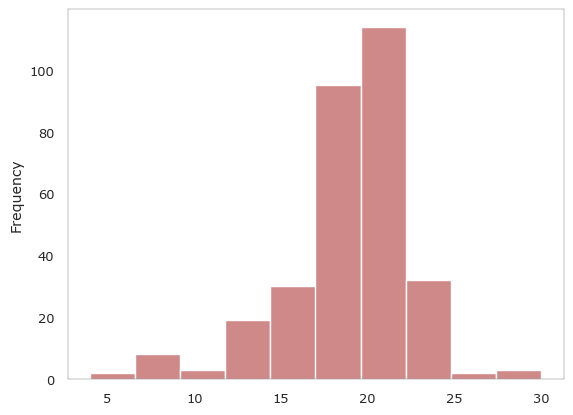

In [265]:
# Visualizing the Target distribution.
y.plot(kind='hist')

Applying a log transform on the target variable.  

In [266]:
# Applying a log transform on the target variable.                                                                            
y=np.log10(y)
y

0      1.361728
1      1.361728
2      1.361728
3      1.255273
4      1.255273
         ...   
332    1.146128
333    1.342423
334    1.255273
335    1.342423
337    1.361728
Name: course_unit, Length: 308, dtype: float64

Visualizing the target distribution after the log transformation.

<AxesSubplot:ylabel='Frequency'>

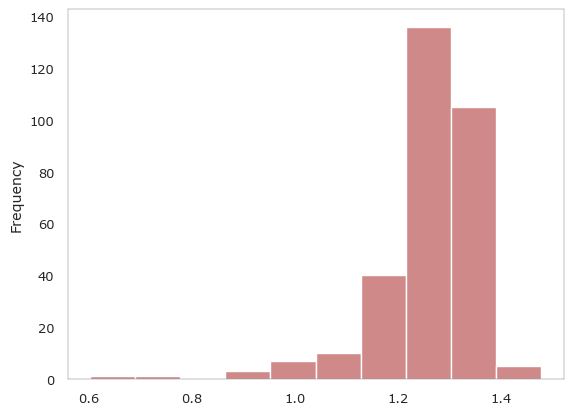

In [267]:
# Visualizing the target distribution after the log transformation.
y.plot(kind='hist')

### Preprocessing

- Create categorical encoder instance to convert categorical data to numerical data. 
- BinaryEncoder is preferred due to the high cardinality of the categorical_columns.
- Create imputer instance to fill up missing data
- Create Principal component analysis instance to reduce the dimension of the data

In [268]:
# Create categorical encoder instance to convert categorical data to numerical data
# BinaryEncoder is preferred due to the high cardinality of the categorical_columns.
encoder = BinaryEncoder(handle_unknown='ignore')

# Create imputer instance to fill up missing data
imputer = SimpleImputer(strategy='mean')

# Create Principal component analysis instance to reduce the dimension of the data
pca = PCA(n_components=2)

# Create model instance
model = lgb.LGBMRegressor(num_leaves=3,max_depth=9,min_data_in_leaf=65)

### Training and test data

Create training and test data

In [269]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Time to train the model!

Create pipeline

In [270]:
model = Pipeline(
    [
        ('cat',encoder),
        ('impute',imputer),
        ('reduction',pca),
        ('model',model)
    ]
)

In [271]:
model.fit(X_train,y_train)


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 246, number of used features: 2
[LightGBM] [Info] Start training from score 1.262878


Pipeline(steps=[('cat',
                 BinaryEncoder(cols=['school', 'level', 'faculty',
                                     'department'],
                               handle_unknown='ignore',
                               mapping=[{'col': 'school',
                                         'mapping':     school_0  school_1
 1         0         1
 2         1         0
-2         0         0},
                                        {'col': 'level',
                                         'mapping':     level_0  level_1  level_2
 1        0        0        1
 2        0        1        0
 3        0        1        1
 4        1        0        0
 5        1        0        1
 6        1        1        0
 7        1        1        1
-2        0        0        0},
                                        {'col': 'faculty',
                                         'mapping':      faculty_0  faculty_1  faculty_2  faculty_3
 1           0          0          0          1
 2           0          0          1          0
 3           0          0          1          1
 4           0          1          0          0
 5           0          1          0          1
 6           0          1          1          0
 7           0          1          1          1...
 56             1             1             1             0             0   
 57             1             1             1             0             0   
 58             1             1             1             0             1   
 59             1             1             1             0             1   
-2              0             0             0             0             0   

     department_5  
 1              1  
 2              0  
 3              1  
 4              0  
 5              1  
 6              0  
 7              1  
 8              0  
 9              1  
 10             0  
 11             1  
 12             0  
 13             1  
 14             0  
 15             1  
 16             0  
 17             1  
 18             0  
 19             1  
 20             0  
 21             1  
 22             0  
 23             1  
 24             0  
 25             1  
 26             0  
 27             1  
 28             0  
 29             1  
 30             0  
 31             1  
 32             0  
 33             1  
 34             0  
 35             1  
 36             0  
 37             1  
 38             0  
 39             1  
 40             0  
 41             1  
 42             0  
 43             1  
 44             0  
 45             1  
 46             0  
 47             1  
 48             0  
 49             1  
 50             0  
 51             1  
 52             0  
 53             1  
 54             0  
 55             1  
 56             0  
 57             1  
 58             0  
 59             1  
-2              0  }])),
                ('impute', SimpleImputer()), ('reduction', PCA(n_components=2)),
                ('model',
                 LGBMRegressor(max_depth=9, min_data_in_leaf=65,
                               num_leaves=3))])

### Model Evaluation

What is our accuracy like?

In [272]:
# Predict on the test data
y_test_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test data
rmse_cu = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared (coefficient of determination) on the test data
r2_cu = r2_score(y_test, y_test_pred)

print("Root Mean Squared Error (RMSE):", rmse_cu)
print("R-squared (Coefficient of Determination):", r2_cu)

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
Root Mean Squared Error (RMSE): 0.08546664749775193
R-squared (Coefficient of Determination): 0.22861637254271205


In [273]:
print(np.exp(rmse_cu))

1.089225232351227


### Time to predict the missing values

In [274]:
# Use the trained model to predict the missing values
X_invalid = invalid_course_units.drop(columns=['course_unit'])
predicted_cu_values = np.exp(model.predict(X_invalid))

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


In [275]:
# Assign the predicted values to the training data
invalid_course_units.loc[invalid_course_units.index, 'course_unit'] = np.round(predicted_cu_values)
invalid_course_units.head()

C:\Users\User\AppData\Local\Temp\ipykernel_18544\2687384307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_course_units.loc[invalid_course_units.index, 'course_unit'] = np.round(predicted_cu_values)


,school,level,faculty,department,courses_taken,course_unit
3,university of lagos,400 Level,Social Sciences,Political science,7,3.0
12,university of lagos,500 Level,Engineering,Surveying & geo-informatics engineering,10,4.0
17,university of lagos,100 Level,Sciences,Marine science,9,4.0
18,university of lagos,400 Level,Engineering,Chemical engineering,10,4.0
19,university of lagos,400 Level,Management Science,Finance,6,3.0


In [276]:
invalid_course_units.nunique()

school            3
level             6
faculty          11
department       41
courses_taken    12
course_unit       2
dtype: int64

#### Merging the predicted values

Now let's merge the predicted values to the general dataframe.

Create a copy of the previous dataframe, to prevent errors.

In [277]:
df_clean = data.copy()

Add the predicted values.

In [278]:
changed_rows = invalid_course_units.index

In [279]:
df_clean.loc[changed_rows, "course_unit"] = invalid_course_units["course_unit"]

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   school         429 non-null    category
 1   level          429 non-null    category
 2   age            429 non-null    Int64   
 3   gender         429 non-null    category
 4   relationship   429 non-null    category
 5   faculty        429 non-null    category
 6   department     429 non-null    category
 7   strike_effect  343 non-null    string  
 8   challenge      338 non-null    string  
 9   work           429 non-null    category
 10  skills         429 non-null    string  
 11  prep_before    429 non-null    category
 12  prep_after     429 non-null    category
 13  lecture        429 non-null    category
 14  academic_act   429 non-null    category
 15  courses_taken  429 non-null    Int64   
 16  course_unit    429 non-null    Int64   
 17  cgpa_before    429 non-null    Floa

## Exploding Skills

The skills column was a checkbox containing 5 options. Participants could choose any combination of these options. For easier processing, we need to explode this column such that we create a different column for each feature.

- Volunteered for an event or organization -> skill_volunteer
- Acquired skills relevant to course of study -> skill_relevant
- Acquired skills unrelated to course of study -> skill_unrelated
- Vocational training and artisanship -> skill_artisan
- None of the above -> skill_none

We're also counting the number of skills each participant acquired in the `skill_count` column.

In [280]:
# Map checkbox options to new column names
skill_mapping = {
    'Volunteered for an event or organization': 'skill_volunteer',
    'Acquired skills relevant to course of study': 'skill_relevant',
    'Acquired skills unrelated to course of study': 'skill_unrelated',
    'Vocational training and artisanship': 'skill_artisan',
    'None of the above': 'skill_none'
}

# Split the skills and create new columns for each skill
for skill_option, new_column_name in skill_mapping.items():
    df_clean[new_column_name] = df_clean['skills'].apply(lambda x: skill_option in x)

# Calculate the total number of skills for each participant
skill_columns = [col for col in df_clean.columns if "skill" in col and col != "skill_none"]
df_clean['skill_count'] = df_clean[skill_columns].sum(axis=1)

# Drop the original 'Skills' column
df_clean = df_clean.drop('skills', axis=1)

df_clean.head()

C:\Users\User\AppData\Local\Temp\ipykernel_18544\3570876988.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_clean['skill_count'] = df_clean[skill_columns].sum(axis=1)


,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,...,course_unit,cgpa_before,cgpa_after,cgpa_change,skill_volunteer,skill_relevant,skill_unrelated,skill_artisan,skill_none,skill_count
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,...,23,3.39,3.51,0.12,False,False,True,False,False,1
1,university of lagos,400 Level,23,Female,Single,Engineering,Chemical engineering,It affected it in a negative way as it became ...,"Rekindling the student in me, lol. Trying to g...",Did not work during the strike,...,23,4.44,4.5,0.06,False,False,True,False,False,1
2,university of lagos,400 Level,21,Male,Dating,Engineering,Chemical engineering,It has actually helped me a bit. The extended ...,Readapting to school,Worked in a role unrelated to my studies,...,23,3.54,3.61,0.07,True,False,True,False,False,2
3,university of lagos,400 Level,29,Male,Dating,Social Sciences,Political science,Good,Reading,Worked in a role unrelated to my studies,...,3,3.86,3.96,0.1,False,False,True,False,False,1
4,university of lagos,100 Level,18,Female,Single,Engineering,Computer engineering,<NA>,<NA>,Worked in a role relevant to my studies,...,18,0.0,4.28,4.28,True,True,True,False,False,3


Are there cases where people claimed both "None of the above" and chose a skill?

In [281]:
false_no_skill = df_clean[(df_clean['skill_none'] == True) & (df_clean['skill_count'] > 0)]

false_no_skill

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,...,course_unit,cgpa_before,cgpa_after,cgpa_change,skill_volunteer,skill_relevant,skill_unrelated,skill_artisan,skill_none,skill_count
76,university of lagos,200 Level,21,Male,Single,Engineering,Chemical engineering,It made me lose zeal for a bit,Having to read everything all over again,Worked in a role unrelated to my studies,...,23,4.2,4.31,0.11,False,False,False,True,True,1
417,university of lagos,200 Level,20,Female,Single,Management Science,Accounting,<NA>,<NA>,Worked in a role unrelated to my studies,...,3,0.0,3.5,3.5,False,False,False,True,True,1


For such cases, we'll need to change "skill_none" to False. 

In [282]:
false_no_skill_index = false_no_skill.index

df_clean.loc[false_no_skill_index, 'skill_none'] = False

df_clean[(df_clean['skill_none'] == True) & (df_clean['skill_count'] > 0)]

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,...,course_unit,cgpa_before,cgpa_after,cgpa_change,skill_volunteer,skill_relevant,skill_unrelated,skill_artisan,skill_none,skill_count


## Addressing cases of No CGPA

Since the 2022 ASUU strike occured in the first semester, we expect that newly admitted students won't have a CGPA before the strike. In such cases, the participants were told to input "0".

In [283]:
#Extract a dataframe of individuals who had no cgpa before but cgpa after

no_cgpa_before = df_clean[df_clean['cgpa_before'] == 0]

no_cgpa_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 4 to 427
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   school           109 non-null    category
 1   level            109 non-null    category
 2   age              109 non-null    Int64   
 3   gender           109 non-null    category
 4   relationship     109 non-null    category
 5   faculty          109 non-null    category
 6   department       109 non-null    category
 7   strike_effect    83 non-null     string  
 8   challenge        81 non-null     string  
 9   work             109 non-null    category
 10  prep_before      109 non-null    category
 11  prep_after       109 non-null    category
 12  lecture          109 non-null    category
 13  academic_act     109 non-null    category
 14  courses_taken    109 non-null    Int64   
 15  course_unit      109 non-null    Int64   
 16  cgpa_before      109 non-null    Float64 
 1

### No CGPA After? 
At the time of this survey, some students were yet to see their results. Hence, they filled in 0 in the CGPA After column. While their comments may be useful, we can't use the value they inputed in analysis. Therefore, we have to address this.

What proportion of students in the dataframe are victims of this?

In [284]:
percent_affected = len(df_clean[df_clean['cgpa_after'] == 0])/len(data) * 100

f"About {round(percent_affected)}% of students were affected"

'About 9% of students were affected'

How many students have complete info?

In [285]:
len(data[(df_clean['cgpa_before'] != 0.00) & (df_clean['cgpa_after'] != 0)])

313

### Valid CGPA

Now we have a dataframe of students with valid CGPAs. That is, neither CGPA before nor CGPA after = 0.

In [286]:
df_valid_cgpa = df_clean[(df_clean['cgpa_before'] != 0.00) & (df_clean['cgpa_after'] != 0)]

In [287]:
#Checking data information
df_valid_cgpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 428
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   school           313 non-null    category
 1   level            313 non-null    category
 2   age              313 non-null    Int64   
 3   gender           313 non-null    category
 4   relationship     313 non-null    category
 5   faculty          313 non-null    category
 6   department       313 non-null    category
 7   strike_effect    253 non-null    string  
 8   challenge        250 non-null    string  
 9   work             313 non-null    category
 10  prep_before      313 non-null    category
 11  prep_after       313 non-null    category
 12  lecture          313 non-null    category
 13  academic_act     313 non-null    category
 14  courses_taken    313 non-null    Int64   
 15  course_unit      313 non-null    Int64   
 16  cgpa_before      313 non-null    Float64 
 1

## Saving our dataframes!

Now that we're done cleaning, it's time to save all our dataframes for use in the analysis files!

In [288]:
# cleaned data before course unit prediction and removal of invalid cgpa
data.to_csv("../data/data_without_predicted_course_units.csv", header=True, index=False)

# cleaned data after course unit prediction
df_clean.to_csv("../data/data_with_predicted_course_units.csv", header=True, index=False)

# contains students lacking complete cgpa info and predicted course units
no_cgpa_before.to_csv("../data/incomplete_cgpa_only.csv", header=True, index=False)

# contains only valid cgpa and predicted course units
df_valid_cgpa.to_csv("../data/valid_cgpa_only.csv", header=True, index=False)